In [9]:
#import will2live

In [10]:
### In this cell is everything done in the previous notebook, avoiding having to mess with file saving to make things simpler ( and avoid git max size issues) 
### any edits to the cleaning-- we should do in the previous notebook and later paste them here  

Error: File 'archive.zip' not found.


C:\Users\danny\AppData\Local\Temp\ipykernel_27072\1884933557.py:36: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book_df = pd.read_csv(file_path)


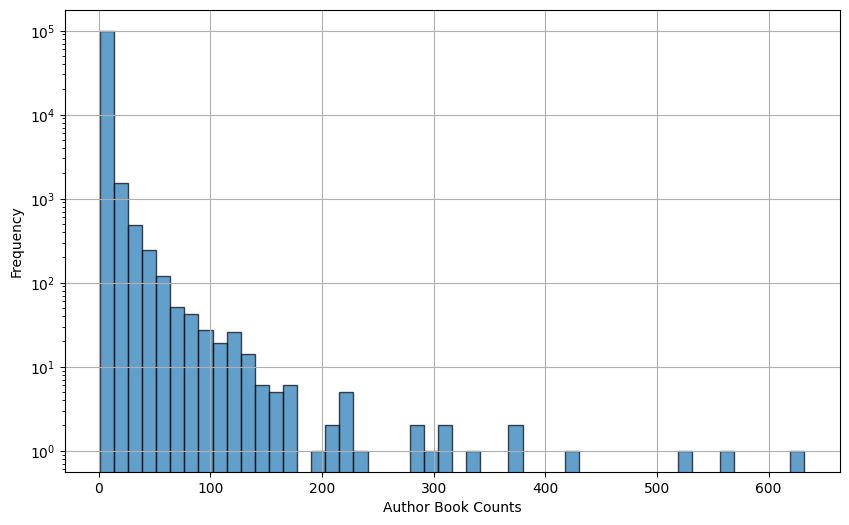

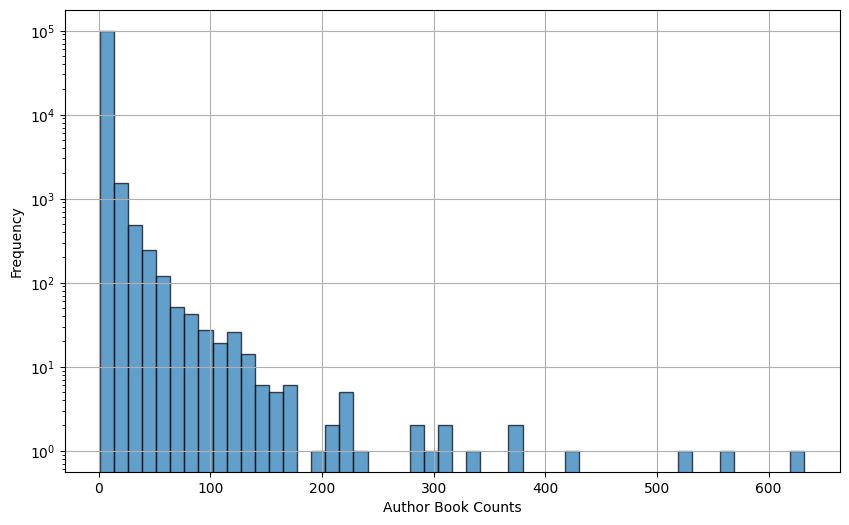

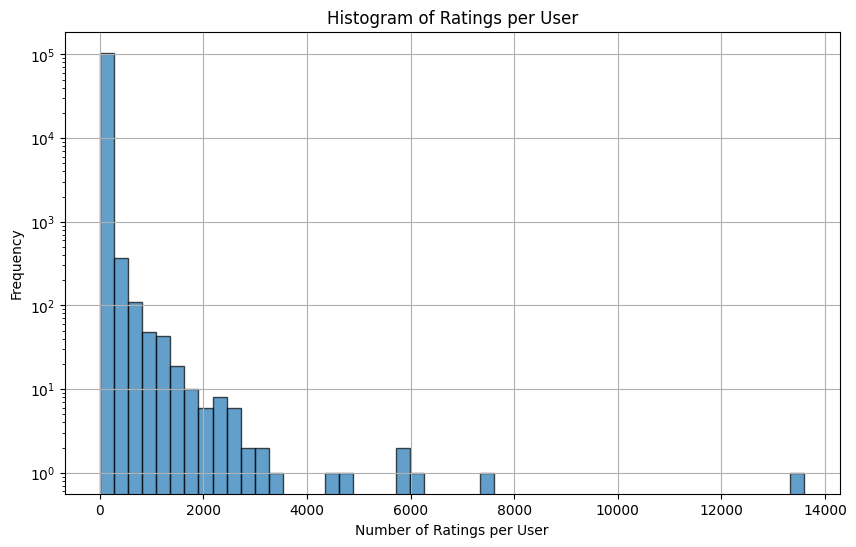

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          1031136 non-null  int64  
 3   Book-Title           1031136 non-null  object 
 4   Book-Author          1031134 non-null  object 
 5   Year-Of-Publication  1031136 non-null  object 
 6   Publisher            1031134 non-null  object 
 7   Image-URL-S          1031136 non-null  object 
 8   Image-URL-M          1031136 non-null  object 
 9   Image-URL-L          1031132 non-null  object 
 10  Location             1031136 non-null  object 
 11  Age                  753301 non-null   float64
dtypes: float64(1), int64(2), object(9)
memory usage: 94.4+ MB
User-ID percent missing:  0.0
ISBN percent missing:  0.0
Book-Rating percent missing:  0.0
Book-

In [11]:
import requests
import pandas as pd
import time
import Levenshtein
from tqdm import tqdm  # Import tqdm for progress bar
import os
import zipfile
import matplotlib.pyplot as plt


def unpack_zip_to_parent(zip_path):
    """Unpacks the given .zip file to the parent directory of the current folder."""
    
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)

    # Ensure the zip file exists
    if not os.path.isfile(zip_path):
        print(f"Error: File '{zip_path}' not found.")
        return

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(parent_dir)
        print(f"Successfully extracted '{zip_path}' to '{parent_dir}'")
    except zipfile.BadZipFile:
        print("Error: Not a valid ZIP file.")
    except Exception as e:
        print(f"An error occurred: {e}")

zip_file = "archive.zip"
unpack_zip_to_parent(zip_file)

parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
file_path = os.path.join(parent_directory, "Books.csv")
book_df = pd.read_csv(file_path)
file_path = os.path.join(parent_directory, "Users.csv")
user_df = pd.read_csv(file_path)
file_path = os.path.join(parent_directory, "Ratings.csv")
ratings_df = pd.read_csv(file_path)

book_df.head()
book_df['Book-Author'].value_counts()

## Agatha Christie had over 100 books, but not over 600.  So there will be some cleaning we need to do here. 
author_counts = book_df['Book-Author'].value_counts()


plt.figure(figsize=(10, 6))
plt.hist(author_counts, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Author Book Counts')
plt.ylabel('Frequency')
plt.title('')
plt.yscale('log') 
plt.grid(True)
plt.show()

duplicates = book_df.groupby('Book-Title')['ISBN'].nunique()
multiple_isbns = duplicates[duplicates > 1]

# see where books have multiple isbns
duped_titles = book_df[book_df['Book-Title'].isin(multiple_isbns.index)].sort_values(by = 'Book-Title')
duped_titles[duped_titles['Book-Author']=='Agatha Christie']
author_counts = book_df['Book-Author'].value_counts()


plt.figure(figsize=(10, 6))
plt.hist(author_counts, bins=50, edgecolor='black', alpha=0.7)

book_df = book_df.sort_values(by=['Book-Author', 'Book-Title', 'ISBN'])
plt.xlabel('Author Book Counts')
plt.ylabel('Frequency')
plt.title('')
plt.yscale('log') 
plt.grid(True)
plt.show()

ratings_df['User-ID'].value_counts()

### so we'll want to be aware of both the cold-start problem, 
### and some readers who might either be bots or just anomalies
import matplotlib.pyplot as plt


user_id_counts = ratings_df['User-ID'].value_counts()


plt.figure(figsize=(10, 6))
plt.hist(user_id_counts, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings per User')
plt.yscale('log')  # Log scale to better visualize the distribution
plt.grid(True)
plt.show()

user_df
df = ratings_df.merge(book_df,
                  left_on="ISBN",
                  right_on="ISBN").merge(
                      user_df,left_on='User-ID',right_on='User-ID')
df.head(3)

df.info()
for i in df.columns:
    print(i,"percent missing: ",(len(df[df[i].isna()])/len(df)))
    

df[df['Book-Author'].isna()]
df = df.dropna(subset=['Book-Author'])
df.drop(['Image-URL-M','Image-URL-L'],axis=1,inplace=True)


## This should only be run once, if it works. 

'''
#### Identify Duplicates (Same Title + Author, Different ISBN)
isbn_counts = df.groupby(['Book-Title', 'Book-Author'])['ISBN'].nunique()
duplicate_books = isbn_counts[isbn_counts > 1].index  # Titles with multiple ISBNs

#### Choose a Representative ISBN for Each Title-Author Combo
isbn_mapping = {}

for title, author in tqdm(duplicate_books, desc="Processing Duplicate Books", unit="book"):
    subset = df[(df['Book-Title'] == title) & (df['Book-Author'] == author)]
    
    # Pick the most frequent ISBN, fallback to earliest ISBN if there's a tie
    common_isbn = subset['ISBN'].value_counts().idxmax()
    
    # Store mapping
    isbn_mapping[(title, author)] = common_isbn

#### Replace ISBNs in DataFrame
df['ISBN_fix'] = df.apply(
    lambda row: isbn_mapping.get((row['Book-Title'], row['Book-Author']), row['ISBN']),
    axis=1
)
'''

#isbn_df = pd.DataFrame(isbn_mapping.items(), columns=['Title_Author', 'ISBN'])
#isbn_df.to_csv("isbn_mapping.csv", index=False)
loaded_mapping_df = pd.read_csv("isbn_mapping.csv")
loaded_mapping = dict(zip(loaded_mapping_df['Title_Author'], loaded_mapping_df['ISBN']))

df['Title_Author'] = df['Book-Title'] + " || " + df['Book-Author']  # Match format used in mapping
df['ISBN_fix'] = df['Title_Author'].map(loaded_mapping).fillna(df['ISBN'])

df.drop(columns=['Title_Author'], inplace=True)
loaded_mapping_df = pd.read_csv("isbn_mapping.csv")

loaded_mapping = dict(zip(loaded_mapping_df['Title_Author'], loaded_mapping_df['ISBN']))

df[df['User-ID']==11676]
df['Location'].value_counts()
## maybe we can clean this to start, country, or drop.  
df[df['Year-Of-Publication']==0].sort_values(by='Book-Rating',ascending=False)
### so maybe a API call and go off of the ISBN,  then use something simple like
#  levenschtein distance to make sure the book title and author are close before using data for the fixed Year-Of-Publication


### we can also use the levenschtein distance or something similar to determine if there's any books that are really close in title and author but have differnt isbns 

'''

# Google Books API Base URL
GOOGLE_BOOKS_API_URL = "https://www.googleapis.com/books/v1/volumes"

import os
current_dir = os.getcwd()
parent_folder = os.path.dirname(current_dir)
file_path = os.path.join(parent_folder, 'dans_api_key.txt')
with open(file_path, 'r') as file:
    API_KEY = file.read()
'''
df_backup = df.copy(deep=True)
df_backup.head()
'''
# Create combined title-author field for checking similarity
df["Title_Author"] = df["Book-Title"].fillna('') + " " + df["Book-Author"].fillna('')

# Ensure ISBN_fix column exists and clean it
df["ISBN_fix"] = df["ISBN_fix"].astype(str).str.strip()

# Define conditions for when to query the API
def needs_imputation(year):
    return pd.isna(year) or str(year).strip() in ["", "0", "NA", "N/A", "null", "None"]

# Filter ISBNs that require lookup
isbns_to_lookup = df[df["Year-Of-Publication"].apply(needs_imputation)]["ISBN_fix"].tolist()

# Store results
isbn_to_publication_year = {}

# Levenshtein similarity threshold (0.8 means 80% similar)
SIMILARITY_THRESHOLD = 0.8

# Loop through ISBNs that need a Year-Of-Publication with TQDM progress bar
for isbn in tqdm(isbns_to_lookup, desc="Processing ISBNs", unit="ISBN"):
    params = {"q": f"isbn:{isbn}", "key": API_KEY}
    
    try:
        response = requests.get(GOOGLE_BOOKS_API_URL, params=params)
        response.raise_for_status()  # Raise an error for bad responses
        data = response.json()

        # Extract book details if found
        if "items" in data:
            book = data["items"][0]["volumeInfo"]
            title = book.get("title", "Unknown")
            authors = ", ".join(book.get("authors", ["Unknown"]))
            publication_date = book.get("publishedDate", "Unknown")

            # Construct title-author string for comparison
            found_title_author = f"{title} {authors}"

            # Get the correct title-author from your dataset
            correct_title_author = df.loc[df["ISBN_fix"] == isbn, "Title_Author"].values[0]

            # Compute Levenshtein similarity
            similarity_score = Levenshtein.ratio(correct_title_author.lower(), found_title_author.lower())

            if similarity_score >= SIMILARITY_THRESHOLD:
                final_publication_date = publication_date  # Accept the found Year-Of-Publication
            else:
                final_publication_date = "ISBN Mismatch"

            # Store the found year in a dictionary
            isbn_to_publication_year[isbn] = final_publication_date

        else:
            isbn_to_publication_year[isbn] = "Not Found"

        time.sleep(1)  # Prevent hitting API rate limits

    except requests.exceptions.RequestException as e:
        isbn_to_publication_year[isbn] = "Error"

# Apply the found Year-Of-Publication **without modifying any other columns**
df["Year-Of-Publication"] = df.apply(
    lambda row: isbn_to_publication_year.get(row["ISBN_fix"], row["Year-Of-Publication"]) 
    if needs_imputation(row["Year-Of-Publication"]) else row["Year-Of-Publication"],
    axis=1
)

print("✅ Year-Of-Publication values successfully updated!")

'''
'''
current_dir = os.getcwd()
parent_folder = os.path.dirname(current_dir)
csv_file_path = os.path.join(parent_folder, 'output.csv')
df.to_csv(csv_file_path, index=False)
print(f"DataFrame saved to {csv_file_path}")

print("✅ Year-Of-Publication values successfully updated!")

'''
'''
# Create a full ISBN_fix-to-Year mapping
isbn_mapping = df[["ISBN_fix", "Year-Of-Publication"]].set_index("ISBN_fix").to_dict()["Year-Of-Publication"]

# Save mapping to CSV
isbn_mapping_df = pd.DataFrame(isbn_mapping.items(), columns=["ISBN_fix", "Year-Of-Publication"])
isbn_mapping_df.to_csv("isbn_year_mapping.csv", index=False)

print("✅ Full ISBN-to-Year mapping saved as 'isbn_year_mapping.csv'")
'''
isbn_mapping_df = pd.read_csv("isbn_year_mapping.csv")
isbn_mapping = dict(zip(isbn_mapping_df["ISBN_fix"], isbn_mapping_df["Year-Of-Publication"]))

# Function to determine if a value needs imputation
def needs_imputation(year):
    return pd.isna(year) or str(year).strip() in ["", "0", "NA", "N/A", "null", "None"]

# Apply mapping only to missing values
df["Year-Of-Publication"] = df.apply(
    lambda row: isbn_mapping.get(row["ISBN_fix"], row["Year-Of-Publication"]) 
    if needs_imputation(row["Year-Of-Publication"]) else row["Year-Of-Publication"],
    axis=1
)

print("✅ Missing Year-Of-Publication values successfully imputed using saved mapping!")
df
df
isbn_mapping_df = pd.read_csv("isbn_year_mapping.csv")
isbn_mapping = dict(zip(isbn_mapping_df["ISBN_fix"], isbn_mapping_df["Year-Of-Publication"]))

# Function to determine if a value needs imputation
def needs_imputation(year):
    return pd.isna(year) or str(year).strip() in ["", "0", "NA", "N/A", "null", "None"]

# Apply mapping only to missing values
df["Year-Of-Publication"] = df.apply(
    lambda row: isbn_mapping.get(row["ISBN_fix"], row["Year-Of-Publication"]) 
    if needs_imputation(row["Year-Of-Publication"]) else row["Year-Of-Publication"],
    axis=1
)


print("✅ Missing Year-Of-Publication values successfully imputed using saved mapping!")

### NEW STUFF

In [12]:
df.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Location', 'Age',
       'ISBN_fix'],
      dtype='object')

In [13]:
users = df['User-ID'].unique()
items = df['ISBN_fix'].unique()